---
---
# Task 1: Sentence Transformer Implementation
Implement a sentence transformer model using any deep learning framework of your choice. This model should be able to encode input sentences into fixed-length embeddings. Test your implementation with a few sample sentences and showcase the obtained embeddings. Describe any choices you had to make regarding the model architecture outside of the transformer backbone.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

# Step 1: Choose a Pre-trained Transformer Model
# Using DistilBERT for its smaller size and faster performance
MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
transformer_model = AutoModel.from_pretrained(MODEL_NAME)

# Step 2: Define a Pooling Method
# We'll use mean pooling to obtain fixed-length sentence embeddings
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element is the token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Step 3: Encode Sentences and Obtain Fixed-Length Embeddings
def encode_sentences(sentences):
    # Tokenize sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    # Get model output
    with torch.no_grad():
        model_output = transformer_model(**encoded_input)
    # Apply mean pooling to get sentence embeddings
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    return sentence_embeddings

# Step 4: Test the Implementation
sample_sentences = [
    "Artificial Intelligence is transforming the world.",
    "Sentence transformers generate useful sentence embeddings.",
    "The cat sat on top of the mat.",
    "The cat sat on the mat.",
    "The mat sat on the cat."
]

embeddings = encode_sentences(sample_sentences)
print("Embeddings Shape:", embeddings.shape)
print("Embeddings:", embeddings)

Embeddings Shape: torch.Size([5, 768])
Embeddings: tensor([[ 0.1282, -0.0706, -0.0485,  ..., -0.4816,  0.2125, -0.0314],
        [ 0.1568,  0.0198, -0.0725,  ..., -0.1980, -0.4828,  0.0126],
        [-0.1652, -0.0872, -0.1138,  ..., -0.1432,  0.3724, -0.0198],
        [-0.0689, -0.0890, -0.0271,  ..., -0.1694,  0.4186, -0.1253],
        [-0.1334, -0.0533,  0.0601,  ..., -0.1330,  0.4097, -0.1668]])


### Architectural Choices:
1. **Model Selection**: Chose `DistilBERT` due to its efficiency and performance.
2. **Pooling Strategy**: Used mean pooling to derive fixed-length embeddings from token embeddings, 
   as it generally performs well for semantic representation and is simple to implement.
3. **Fixed-Length Representation**: The mean-pooled embeddings ensure that all input sentences 
   have a consistent, fixed-size representation that is suitable for downstream tasks.

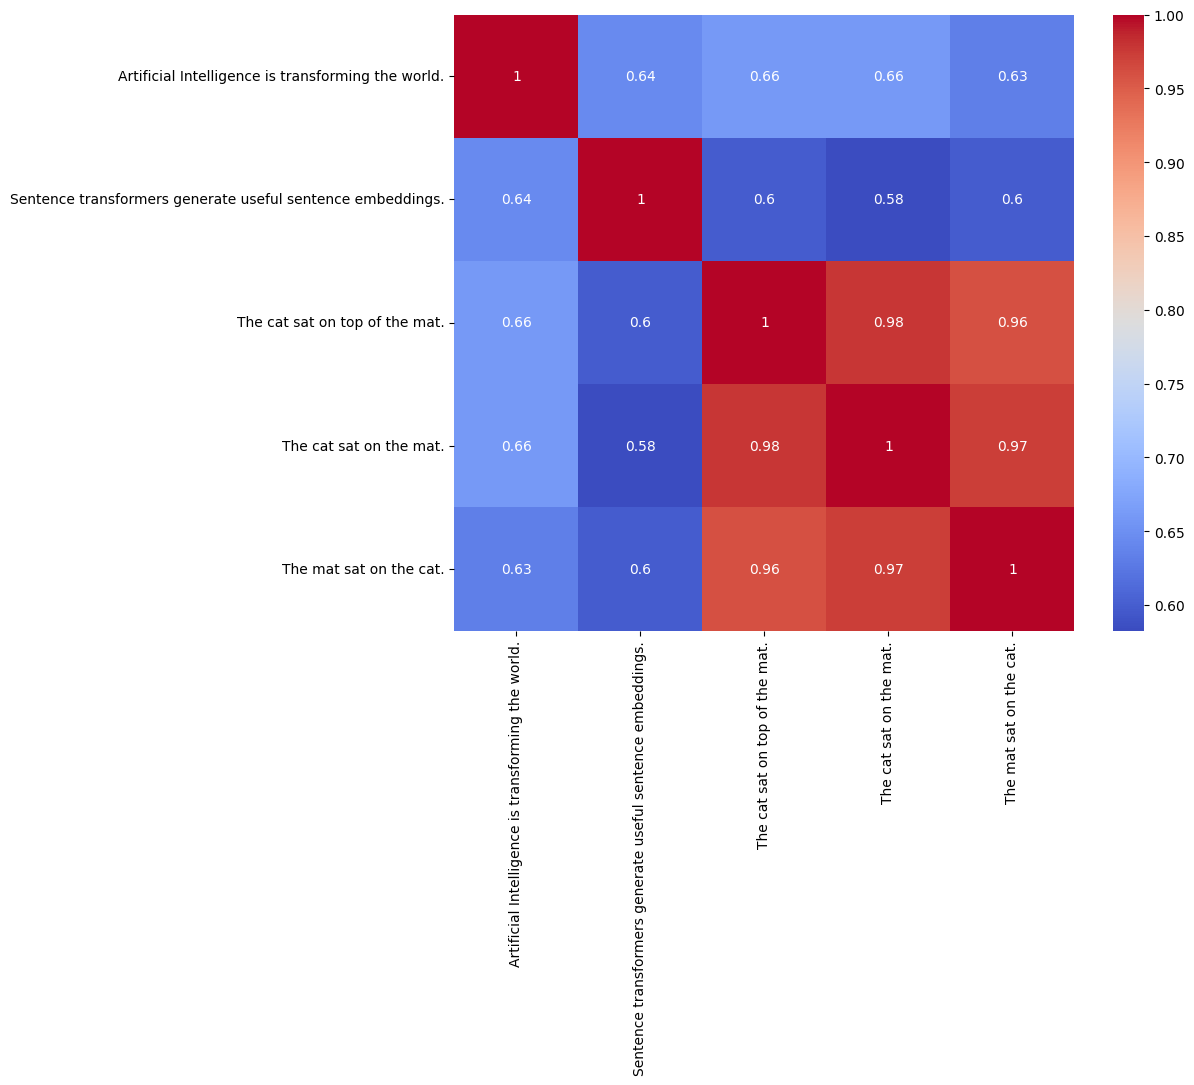

In [ ]:
# comparing the embeddings of all the sentences 
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

similarity_matrix = cosine_similarity(embeddings)
df = pd.DataFrame(similarity_matrix, columns=sample_sentences, index=sample_sentences)
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='coolwarm')
plt.show()

---
---
# Task 2: Multi-Task Learning Expansion
Expand the sentence transformer to handle a multi-task learning setting.
1. Task A: Sentence Classification – Classify sentences into predefined classes (you can make these up).
2. Task B: [Choose another relevant NLP task such as Named Entity Recognition, Sentiment Analysis, etc.] (you can make the labels up)

Describe the changes made to the architecture to support multi-task learning.

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel

# Step 1: Choose a Pre-trained Transformer Model
# Using DistilBERT for its smaller size and faster performance
MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
transformer_model = AutoModel.from_pretrained(MODEL_NAME)

# Step 2: Define a Pooling Method
# We'll use mean pooling to obtain fixed-length sentence embeddings
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element is the token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Step 3: Multi-Task Model Definition
# Expand the sentence transformer to handle multiple tasks
class MultiTaskModel(nn.Module):
    def __init__(self, transformer_model, num_classes_task_a=3, num_classes_task_b=2):
        super(MultiTaskModel, self).__init__()
        self.transformer = transformer_model
        self.task_a_head = nn.Linear(transformer_model.config.hidden_size, num_classes_task_a)  # Task A: Sentence Classification
        self.task_b_head = nn.Linear(transformer_model.config.hidden_size, num_classes_task_b)  # Task B: Sentiment Analysis

    def forward(self, input_ids, attention_mask, task='A'):
        model_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = mean_pooling(model_output, attention_mask)
        if task == 'A':
            return self.task_a_head(pooled_output)  # Classification Head for Task A
        elif task == 'B':
            return self.task_b_head(pooled_output)  # Classification Head for Task B

# Step 4: Encode Sentences and Test Multi-Task Model
def encode_and_classify(sentences, task='A'):
    # Tokenize sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    # Create model and forward pass for the specified task
    model = MultiTaskModel(transformer_model)
    with torch.no_grad():
        logits = model(encoded_input['input_ids'], encoded_input['attention_mask'], task=task)
    return logits

# Step 5: Test the Implementation with Multi-Task Learning
sample_sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "Artificial Intelligence is transforming the world.",
    "Sentence transformers generate useful sentence embeddings."
]

# Test for Task A: Sentence Classification
logits_task_a = encode_and_classify(sample_sentences, task='A')
print("Task A (Sentence Classification) Logits:", logits_task_a)

# Test for Task B: Sentiment Analysis
logits_task_b = encode_and_classify(sample_sentences, task='B')
print("Task B (Sentiment Analysis) Logits:", logits_task_b)

# 3. **Pooling Strategy**: Reused the mean pooling strategy to obtain fixed-length embeddings that are fed into task-specific heads.


Task A (Sentence Classification) Logits: tensor([[-0.0962, -0.0726, -0.0789],
        [ 0.1023,  0.0346,  0.1342],
        [ 0.0800, -0.0983, -0.1764]])
Task B (Sentiment Analysis) Logits: tensor([[ 0.0231, -0.1619],
        [ 0.2292, -0.1566],
        [-0.0713, -0.1368]])


### Architectural Changes Description:
1. **Multi-Task Expansion**: Added two task-specific heads to the model:
   - **Task A Head**: For sentence classification into predefined classes (e.g., positive, neutral, negative).
   - **Task B Head**: For sentiment analysis or another classification task.
2. **Model Forward Logic**: Updated the forward method to select the appropriate head based on the task parameter.

---
---
# Task 3: Training Considerations
Part A: Discuss the implications and advantages of each scenario and explain your rationale as to how the model should be trained given the following:
1. If the entire network should be frozen.
2. If only the transformer backbone should be frozen.
3. If only one of the task-specific heads (either for Task A or Task B) should be frozen.

Part B: Consider a scenario where transfer learning can be beneficial. Explain how you would approach the transfer learning process, including:
1. The choice of a pre-trained model.
2. The layers you would freeze/unfreeze.
3. The rationale behind these choices.

---
### Scenario 1: Freeze the entire network 🥶

#### Implications:
- If you freeze the entire network, none of the parameters will be updated during training. Essentially, you are using the model in an inference-only mode.

#### Advantages:
- This is beneficial if the pre-trained model has already been fine-tuned on a similar task or dataset and you believe that it performs well enough for the current use case.
- It is computationally efficient, as no gradients are calculated, leading to faster inference.
- Useful in situations where training data is scarce, and there's a risk of overfitting.
---
### Scenario 2: Freeze only the transformer backbone 🦴

#### Implications:
Here, the transformer backbone is frozen, but the task-specific heads are trainable. This means the underlying language representation stays fixed, while the output heads are adapted for each specific task.

#### Advantages:
- **Reduced Training Time:** Since only the task heads are being trained, the training process is faster and requires less computational power compared to fine-tuning the entire model.
- **Generalized Features:** Freezing the transformer allows you to leverage its general language understanding while making slight adjustments for task-specific requirements.
- **Overfitting Mitigation:** Since the majority of the parameters (the transformer) are frozen, the risk of overfitting to a small dataset is lower.

#### Rationale: 
This approach is particularly useful when you have limited labeled data for the tasks, but you still want to fine-tune the model to be somewhat task-specific. It is also effective if the tasks are closely related to what the original transformer has been trained on.

---
### Scenario 3: Freeze only one of the task-specific heads 🗿

#### Implications:

In this case, only one task-specific head is frozen, while the transformer backbone and the other task head remain trainable. This means the model will continue learning representations that are relevant to the task with the trainable head.

#### Advantages:
- **Selective Adaptation:** Freezing one head allows you to maintain the performance for a task that is already well-optimized, while continuing to improve the model for another task. 
- **Knowledge Retention:** By freezing one head, you avoid catastrophic forgetting—which means the model will not "forget" what it has already learned for that task, while the other head can still adapt.

#### Rationale:

This is useful in multi-task learning scenarios where tasks have different priorities. For example, if one task (e.g., Task A) is more critical and has already achieved good accuracy, you may want to keep it intact and make further changes only for Task B.

It can also be used when incrementally training a model. You could improve the model for new tasks without losing the previously acquired capabilities.

---
### Summary of Training Considerations:

| Approach | Description | Use Case |
|----------|-------------|----------|
| Entire Network Frozen | Efficient, used when no task-specific fine-tuning is needed | Works well if the pre-trained model is already suitable for the current task |
| Transformer Backbone Frozen | Task heads can adapt to specific requirements, while the model retains general language understanding | Useful for limited data situations |
| One Task Head Frozen | Maintains performance for a well-trained task while focusing on training for another task | Suitable for incremental improvements in multi-task settings where one task is more stable than others |


---
## Real-World Scenario for Transfer Learning ➡️

Consider building an email classification system for a customer support department. This system will classify incoming customer emails into different categories, such as "Billing Issues", "Technical Support", "Product Inquiry", and "Complaints".

### 1. Choice of a Pre-Trained Model

For this scenario, a suitable choice is a pre-trained BERT model or DistilBERT from Hugging Face.

**Rationale:**
- These models are pre-trained on large, diverse corpora like Wikipedia and BooksCorpus, making them highly capable of understanding general language structure and context.
- They can capture nuances and relationships within text, which is particularly useful when dealing with customer queries that involve a wide range of topics and variations in phrasing.
- You WOULD NOT want to choose a pre-trained model like Bio-BERT which is fine-tuned specifically on biomedical text. Such a model would struggle to understand general customer queries.

### 2. Layers to Freeze/Unfreeze

- Initial Layers (Frozen)
    - Freeze the lower layers (e.g., the first 8-10 transformer layers) of the pre-trained BERT model. 
    - By freezing these layers, we retain the rich linguistic features learned during pre-training while reducing training time and mitigating the risk of overfitting, especially if our email dataset is not very large.

- Higher Layers (Unfrozen)
    - Unfreeze the top layers (e.g., the last 2-4 transformer layers). These layers are more specialized and capture task-specific representations. Fine-tuning these layers will allow the model to adapt to the particular context of customer emails, learning features like specific support keywords and domain-specific language (e.g., terms unique to billing, technical support).

- Task-Specific Head (Unfrozen)
    - Add and train a fully connected classification head on top of the transformer model. This head will map the hidden representation output from BERT to the desired email categories.
    - Fine-tune this layer fully to adapt specifically to the email classification task. This allows the model to optimize its output for the email categories we need.

### 3. More Rationale

- Efficient Fine-Tuning
    - Freezing some layers reduces the number of trainable parameters, leading to faster training and lower computational cost, especially when you have a relatively small dataset.
    - Focusing on fine-tuning the upper layers ensures that the model learns specialized features required for the email classification task without deviating too much from the core language representation already built by the lower layers.

- Leveraging Domain-Specific Training Data
    - By utilizing a pre-trained model as a starting point, the amount of task-specific training data needed is greatly reduced. We only need a smaller dataset of labeled emails, as the base model already has a robust understanding of general language.


---
---
# Task 4: Layer-wise Learning Rate Implementation (BONUS) 🌟
Implement layer-wise learning rates for the multi-task sentence transformer.

Explain the rationale for the specific learning rates you've set for each layer.

Describe the potential benefits of using layer-wise learning rates for training deep neural networks. Does the multi-task setting play into that?

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AdamW
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

# Step 1: Model and Tokenizer Setup
MODEL_NAME = "distilbert-base-uncased"

def load_model_and_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    transformer_model = AutoModel.from_pretrained(model_name)
    return tokenizer, transformer_model

tokenizer, transformer_model = load_model_and_tokenizer(MODEL_NAME)

# Step 2: Pooling Method Definition
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element is the token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Step 3: Multi-Task Model Definition
class MultiTaskModel(nn.Module):
    def __init__(self, transformer_model, num_classes_task_a=3, num_classes_task_b=2):
        super(MultiTaskModel, self).__init__()
        self.transformer = transformer_model
        self.task_a_head = nn.Linear(transformer_model.config.hidden_size, num_classes_task_a)  # Task A: Sentence Classification
        self.task_b_head = nn.Linear(transformer_model.config.hidden_size, num_classes_task_b)  # Task B: Sentiment Analysis

    def forward(self, input_ids, attention_mask, task='A'):
        model_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = mean_pooling(model_output, attention_mask)
        if task == 'A':
            return self.task_a_head(pooled_output)  # Classification Head for Task A
        elif task == 'B':
            return self.task_b_head(pooled_output)  # Classification Head for Task B

# Step 4: Optimizer Setup
def setup_optimizer(model, base_lr=1e-5):
    optimizer = AdamW([
        {"params": model.transformer.transformer.layer[:4].parameters(), "lr": base_lr * 0.5},  # Lower layers, smaller learning rate
        {"params": model.transformer.transformer.layer[4:].parameters(), "lr": base_lr},  # Middle layers, base learning rate
        {"params": model.task_a_head.parameters(), "lr": base_lr * 10},  # Task A head, higher learning rate for better task adaptation
        {"params": model.task_b_head.parameters(), "lr": base_lr * 10}   # Task B head, higher learning rate for better task adaptation
    ])
    return optimizer

# Step 5: Training Loop Definition
def train_model(model, tokenizer, optimizer, sentences, labels, task='A', epochs=3):
    criterion = CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        # Tokenize sentences
        encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
        input_ids = encoded_input['input_ids']
        attention_mask = encoded_input['attention_mask']

        # Forward pass
        logits = model(input_ids, attention_mask, task=task)

        # Compute loss
        labels_tensor = torch.tensor(labels)
        loss = criterion(logits, labels_tensor)

        # Backward pass
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Step 6: Model Instantiation and Training
model = MultiTaskModel(transformer_model)
optimizer = setup_optimizer(model)

# Sample data for training Task A
sample_sentences_a = [
    "The quick brown fox jumps over the lazy dog.",
    "Artificial Intelligence is transforming the world.",
    "Sentence transformers generate useful sentence embeddings."
]

# Example labels for Task A (assuming 3 classes)
sample_labels_a = [0, 1, 2]

# Train the model for Task A
print("Training Task A Model:")
train_model(model, tokenizer, optimizer, sample_sentences_a, sample_labels_a, task='A')

# Sample data for training Task B
sample_sentences_b = [
    "I am very happy with the service.",
    "The product quality is terrible.",
    "The experience was okay, not great but not bad either."
]

# Example labels for Task B (assuming 2 classes: Positive and Negative)
sample_labels_b = [1, 0, 1]

# Train the model for Task B
print("\nTraining Task B Model:")
train_model(model, tokenizer, optimizer, sample_sentences_b, sample_labels_b, task='B')


Training Task A Model:
Epoch 1/3, Loss: 1.0469402074813843
Epoch 2/3, Loss: 0.9972613453865051
Epoch 3/3, Loss: 0.9562293887138367

Training Task B Model:
Epoch 1/3, Loss: 0.7385020852088928
Epoch 2/3, Loss: 0.6937822699546814
Epoch 3/3, Loss: 0.6657078266143799


### Rationale for Specific Learning Rates:
  - Lower Layers (0.5 * base_lr):
    - These capture general linguistic features shared across tasks. A lower learning rate preserves their pre-trained knowledge, avoiding drastic changes.
  - Middle Layers (base_lr):
    - These require some adaptation to the specific dataset, making moderate adjustments with the base learning rate.
  - Task Heads (10 * base_lr):
    - Task-specific heads are initialized from scratch and need rapid learning, hence a higher learning rate.

### Potential Benefits of Layer-wise Learning Rates:
  - Efficient Adaptation:
    - Different learning rates help balance between:
      - Maintaining general language understanding (in lower layers)
      - Adapting specific parts of the model (task heads)
  - Avoid Overfitting/Underfitting:
    - Gradual changes to lower layers help avoid overfitting
    - Higher rates in task heads speed up task-specific adaptation

### Multi-Task Setting:
  - Layer-wise learning rates help:
    - Share general features learned in the lower layers across tasks
    - Allow task-specific heads to diverge and specialize independently
  - Benefits:
    - Efficient parameter sharing
    - No compromise on task-specific performance
    - Useful for handling varying levels of task complexity:
      - Slower rates for easily transferable tasks
      - Faster rates for tasks requiring rapid adaptation